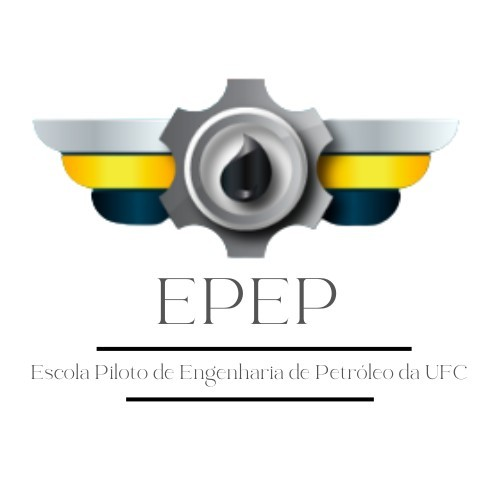
## Introdução


### Arquivos DLIS
Existem vários formatos diferentes nos quais os dados petrofísicos e de perfis de poço podem ser armazenados. Os arquivos DLIS são usados para representar informações capturadas durante o processo de perfuração e avaliação de poços, como dados de perfis geofísicos, pressões, temperaturas e outros parâmetros relevantes.

Os arquivos DLIS são um padrão binário que foi desenvolvido para facilitar a troca de informações entre diferentes sistemas de software e equipamentos utilizados na exploração e produção de hidrocarbonetos. Eles permitem que as empresas e os profissionais da indústria compartilhem dados de maneira eficiente e precisa, garantindo que as informações sejam preservadas e interpretadas corretamente ao longo do tempo.

Os arquivos DLIS contêm grandes quantidades de metadados associados ao poço e aos dados. Essas seções não contêm os dados do poço, eles são armazenados em frames, dos quais podem haver muitos representando diferentes passes/execuções de perfilagem ou estágios de processamento (por exemplo, Raw(Bruto) ou Interpretado). Os frames são objetos de tabela que contêm os dados de perfil do poço, onde cada coluna representa uma curva de perfilagem e esses dados são indexados por tempo ou profundidade. Cada curva de perfilagem dentro do frame é referida como um canal. Os canais podem ser unidimensionais ou multidimensionais.

### Biblioteca dlisio
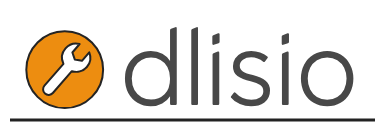
Dlisio foi projetada como uma biblioteca de uso geral para ler registros de poços de maneira simples e fácil de usar. Seu foco principal é tornar todos os dados e metadados acessíveis, colocando algumas suposições sobre como os dados devem ser usados. Isso a torna adequada como um bloco de construção para aplicações de nível superior, bem como para ser usado diretamente. A biblioteca dá ao usuário a possibilidade de trabalhar com os arquivos LIS e DLIS sem ter que conhecer todos os detalhes do próprio padrão.


### Dados
Os dados usados para esse artigo foram obtidos pelo site REATE da ANP (Agência Nacional do Petróleo, Gás Natural e Biocombustíveis). O site foi lançado a fim de disponibilizar gratuitamente os dados técnicos públicos digitais de bacias sedimentares terrestres, num total de 23, e possui dados digitais de poços, dados sísmicos 2D e 3D pós-stack, dados não-sísmicos, dados geoquímicos e estudos diversos. Os 23 pacotes de dados contêm informações referentes a 22.641 poços, 329 levantamentos sísmicos 2D, 204 levantamentos sísmicos 3D, 217 levantamentos não-sísmicos (gravimetria, magnetometria, magnetotelúrica e gamaespectometria), 38 levantamentos geoquímicos, e 17 estudos existentes no acervo de dados técnicos do Banco de Dados de Exploração e Produção da ANP (BDEP). O site pode ser acessado em: https://reate.cprm.gov.br/anp/TERRESTREen .

**Aviso de Privacidade:** Os arquivos DLIS podem conter informações que podem identificar indivíduos envolvidos nas operações de registro.


## Importação das Bibliotecas 

O primeiro passo de qualquer projeto é carregar as bibliotecas que queremos usar.
Para este notebook usaremos [NumPy](https://numpy.org) para trabalhar com arrays, [pandas](https://pandas.pydata.org) para armazenar dados e [matplotlib](https:/ /matplotlib.org) para exibir os dados. Para carregar os dados, usaremos a biblioteca [dlisio](https://github.com/equinor/dlisio).

Além disso, utilizaremos bibliotecas para os gráficos: matplotlib e seaborn.

Além disso, como trabalharemos com dataframes para visualizar parâmetros, que podem ser numerosos, precisamos alterar o número máximo de linhas que serão exibidas quando aquele dataframe for chamado. Isto é conseguido por `pd.set_option('display.max_rows', 500)`.

In [3]:
from dlisio import dlis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as sts
import seaborn as srn
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

pd.set_option('display.max_rows', 500)

### Carregando um arquivo DLIS

Como estamos trabalhando com um único arquivo DLIS, podemos usar o código a seguir para carregar o arquivo. Um arquivo DLIS físico pode conter vários arquivos lógicos, portanto, o uso dessa sintaxe permite que o primeiro arquivo seja enviado para `f` e quaisquer arquivos lógicos subsequentes colocados em `tail`.

In [4]:
f,*tail = dlis.load('4-brsa-814d-rn_raw2.dlis')

Podemos ver o conteúdo de cada um deles invocando seus nomes. Se chamarmos `f`, podemos ver que ele retorna um `LogicalFile()` e se chamarmos `tail`, obteremos uma lista em branco, que nos permite saber que não há outros arquivos lógicos dentro do DLIS.

In [5]:
print(f)
print(tail)

LogicalFile(GEOLOAD.1)
[LogicalFile(GEOLOAD.2)]


Para visualizar o conteúdo de alto nível do arquivo, podemos usar o método `.describe()`. Isso retorna informações sobre o número de quadros, canais e objetos dentro do Arquivo Lógico. Quando aplicamos isso a `f` podemos ver que temos um arquivo com 1 frame e 374 canais (Perfis de poço), além de uma série de objetos conhecidos e desconhecidos.

In [6]:
f.describe()

------------
Logical File
------------
Description : LogicalFile(GEOLOAD.1)
Frames      : 1
Channels    : 374

Known objects
--
PARAMETER   : 151
TOOL        : 9
ORIGIN      : 1
COMMENT     : 2
NO-FORMAT   : 1
FRAME       : 1
FILE-HEADER : 1
CHANNEL     : 374

Unknown objects
--
280-FRAMESTEP-INFO : 1


In [7]:
tail[0].describe()

------------
Logical File
------------
Description : LogicalFile(GEOLOAD.2)
Frames      : 1
Channels    : 376

Known objects
--
PARAMETER   : 151
TOOL        : 8
ORIGIN      : 1
COMMENT     : 2
NO-FORMAT   : 1
FRAME       : 1
FILE-HEADER : 1
CHANNEL     : 376

Unknown objects
--
280-FRAMESTEP-INFO : 1


## Visualizando os metadados do arquivo

### Frames

Os frames dentro de um arquivo DLIS podem representar diferentes passagens de perfilagem ou diferentes estágios de dados, como medições de perfil de poço bruto para interpretações físico-físicas ou dados processados. Cada frame possui diversas propriedades. O código de exemplo abaixo imprime as propriedades em um formato de fácil leitura.

In [8]:
f.frames

[Frame(50)]

In [9]:
for frame in f.frames:
    
    # Pesquisa nos canais o índice e obtem as unidades
    for channel in frame.channels:
        if channel.name == frame.index:
            depth_units = channel.units
    
    print(f'Nome do Frame: \t\t\t {frame.name}')
    print(f'Tipo de Índice: \t\t {frame.index_type}')
    print(f'Intervalo de Profundidade: \t {frame.index_min} - {frame.index_max} {depth_units}')
    print(f'Espaçamento de profundidade: \t {frame.spacing} {depth_units}')
    print(f'Direção: \t\t\t {frame.direction}')
    print(f'Número de Canais: \t\t {len(frame.channels)}')
    print(f'Nome dos Canais:\n{str(frame.channels)}')
    print('\n\n')

Nome do Frame: 			 50
Tipo de Índice: 		 BOREHOLE-DEPTH
Intervalo de Profundidade: 	 None - None m
Espaçamento de profundidade: 	 -0.10000000149011612 m
Direção: 			 DECREASING
Número de Canais: 		 374
Nome dos Canais:
[Channel(TDEP), Channel(TIM), Channel(TDA), Channel(ACCZ), Channel(INCL), Channel(ETIME), Channel(TVD), Channel(TVDSS), Channel(VERTICALSE), Channel(TIM1), Channel(TDA1), Channel(ACCZ1), Channel(DXT2), Channel(ETIME1), Channel(TVD1), Channel(TVDSS1), Channel(VERTICALS1), Channel(TIM2), Channel(TDA2), Channel(BTMP), Channel(ETIME2), Channel(TVD2), Channel(TVDSS2), Channel(VERTICALS2), Channel(TIM3), Channel(TDA3), Channel(BTMP1), Channel(ETIME3), Channel(TVD3), Channel(TVDSS3), Channel(VERTICALS3), Channel(TIM4), Channel(TDA4), Channel(DLOD), Channel(DHLP), Channel(DHLN), Channel(DHTN), Channel(ETIME4), Channel(TVD4), Channel(TVDSS4), Channel(VERTICALS4), Channel(TIM5), Channel(TDA5), Channel(PLTC), Channel(NPHI), Channel(NDSN), Channel(FDSN), Channel(NRAT), Channel(NLIT)

### Parâmetros dentro do arquivo DLIS
Como visto anteriormente, temos vários objetos associados ao arquivo DLIS. Para torná-los mais fáceis de ler, podemos criar uma função curta que cria um dataframe do pandas contendo os parâmetros.

In [10]:
def summary_dataframe(object, **kwargs):
    # Cria um dataframe vazio
    df = pd.DataFrame()
    
    # Iterar sobre cada um dos argumentos da palavra-chave
    for i, (key, value) in enumerate(kwargs.items()):
        list_of_values = []
        
        # Itera sobre cada parâmetro e obtem a chave relevante
        for item in object:
            # Considera quaisquer valores ausentes.
            try:
                x = getattr(item, key)
                list_of_values.append(x)
            except:
                list_of_values.append('')
                continue
        
        # Adiciona uma nova coluna ao nosso dataframe
        df[value]=list_of_values
    
    # Classifica o dataframe pela coluna 1 e o retorna
    return df.sort_values(df.columns[0])
    

Os parâmetros podem ser acessados ​​chamando `f.parameters`. Para acessar os parâmetros, podemos usar os atributos `nome`, `nome completo` e `valor` e passá-los para a função de resumo.

Isso retorna uma longa tabela de cada um dos parâmetros. O exemplo abaixo é uma pequena seção dessa tabela. A partir dele, podemos ver parâmetros como intervalo de perfil inferior, salinidade do poço e temperatura do fundo do poço.

In [11]:
param_df = summary_dataframe(f.parameters, name='Nome', long_name='Nome Completo', values='Valor')

param_df

,Nome,Nome Completo,Valor
0,APD,ABOVE PERMANENT DATUM,[147.0]
1,APIN,API WELLHOLE NUMBER,[72100024599]
2,BAP,Elevation of Ground Level,[137.4]
3,BARI,BARITE CORRECTION,[OFF]
4,BASI,BASIN,[POTIGUAR TERRA]
5,BHT,BOTTOMHOLE TEMPERATURE,[210.0]
6,BLI,BOTTOM LOGGED INTERVAL,[3284.4]
7,BS,BIT SIZE,[8.5]
8,BS1,BIT SIZE 1,[17.5]
9,BS2,BIT SIZE 2,[12.25]


### Canais

Os canais dentro de um frame são curvas ou matrizes individuais. Para ver um rápido resumo deles, podemos passar vários atributos para o método `summary_dataframe()`.

In [12]:
channels = summary_dataframe(f.channels, name='Nome', long_name='Nome Completo', dimension='Dimensão' , units='Unidades', frame='Frame')
channels

,Nome,Nome Completo,Dimensão,Unidades,Frame
278,5VD,5VD/Plus5VoltDC,[1],V,Frame(50)
274,5VOL,5VOL/FiveVolts,[1],V,Frame(50)
224,AC,AC/Ac,[1],ppm,Frame(50)
185,ACAL,ACAL/Caliper Arm,[1],in,Frame(50)
3,ACCZ,ACCZ/AccZ,[1],g,Frame(50)
11,ACCZ1,ACCZ1/AccZ,[1],g,Frame(50)
284,ACQN,ACQN/ACQ Number,[1],NONE,Frame(50)
231,ACT,ACT/T/D Activity,[15],NONE,Frame(50)
253,ACV,ACV/AuxSetVoltage,[1],V,Frame(50)
181,AHV,AHV/AHV Inc,[1],m3,Frame(50)


## Trabalhando com objetos de dados

Agora que alguns dos metadados foram explorados, podemos tentar acessar os dados armazenados no arquivo.

Quadros e dados podem ser acessados ​​chamando `.object()` para o arquivo. Primeiro, podemos atribuir os frames a variáveis, o que facilitará o acesso aos dados dentro deles, principalmente se os frames contiverem canais/curvas com o mesmo nome. O método `.object()` requer o tipo de objeto que está sendo acessado, ou seja, 'FRAME' ou 'CHANNEL' e seu nome. Neste caso podemos voltar ao passo anterior que contém os canais e os nomes dos quadros. Podemos ver que as curvas básicas de perfilagem estão em um quadro e os dados acústicos estão em outro.

In [13]:
frame1 = f.object('FRAME','50')
frame1

Frame(50)

In [14]:
parametro1 = f.object('PARAMETER','CN')
print(f'Nome: \t\t{parametro1.values}')

Nome: 		['PETROBRAS']


Para ver um exemplo de forma individual, fazemos como o código abaixo está representado.

In [15]:
dtc = f.object('CHANNEL', 'BS')

# Imprima as propriedades do canal/curva
print(f'Nome: \t\t{dtc.name}')
print(f'Nome Completo: \t{dtc.long_name}')
print(f'Unidade: \t{dtc.units}')
print(f'Dimensão: \t{dtc.dimension}') # Se >1, então os dados são uma matriz

Nome: 		BS
Nome Completo: 	BS/Bit Size
Unidade: 	in
Dimensão: 	[1]


## Criação do dataframe dos perfis do poço

Depois de ver várias informações sobre o arquivo, agora iremos criar um dataframe com os principais perfis que existem no arquivo e são importantes para compreender as propriedades do poço.

In [16]:
logicalfile1 = f.object('FRAME', '50')
logicalfile2 = tail[0].object('FRAME', '50')

curves = logicalfile1.curves()

colunas_para_extrair = ['TDEP', 'CALI', 'PE', 'BS', 'TENS', 'GR', 'SP', 'RHOB', 'NPHI', 'DT', 'DPHI','DRHO', 'HDRS', 'HMRS', 'HO30', 'HO90', 'HT30', 'HT90','ITTI']

df_total = np.stack([curves[col] for col in colunas_para_extrair], axis=1)
df_total = pd.DataFrame(df_total, columns=colunas_para_extrair)
df_total

,TDEP,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
0,3292.699951,-999.250000,-999.250000,8.50,4043.570801,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
1,3292.599951,-999.250000,-999.250000,8.50,4133.763672,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
2,3292.499951,-999.250000,-999.250000,8.50,4229.158691,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3,3292.399951,-999.250000,-999.250000,8.50,4299.518555,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
4,3292.299951,-999.250000,-999.250000,8.50,4386.285645,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1475.099924,8.772648,12.149636,8.50,4069.784668,42.821945,91.547577,1.388366,0.271560,58.389324,0.764627,-1.505307,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.3771
18177,1474.999924,8.765101,12.178725,8.50,4054.540527,42.988327,91.461975,1.391309,0.278701,58.389324,0.762843,-1.503994,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.5795
18178,1474.899924,8.766973,12.163946,8.50,4037.984619,43.042995,91.499832,1.381256,0.299450,57.801666,0.768936,-1.504028,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,14.4989
18179,1474.799924,8.767343,12.134694,8.50,4045.207764,43.501736,91.503693,1.370852,0.296088,57.801666,0.775241,-1.505951,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,14.4989


In [17]:
# Tornar a profundidade como índice do dataframe
df_total.set_index('TDEP', inplace=True)

In [18]:
df_total

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
TDEP,,,,,,,,,,,,,,,,,,
3292.699951,-999.250000,-999.250000,8.50,4043.570801,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.599951,-999.250000,-999.250000,8.50,4133.763672,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.499951,-999.250000,-999.250000,8.50,4229.158691,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.399951,-999.250000,-999.250000,8.50,4299.518555,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.299951,-999.250000,-999.250000,8.50,4386.285645,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475.099924,8.772648,12.149636,8.50,4069.784668,42.821945,91.547577,1.388366,0.271560,58.389324,0.764627,-1.505307,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.3771
1474.999924,8.765101,12.178725,8.50,4054.540527,42.988327,91.461975,1.391309,0.278701,58.389324,0.762843,-1.503994,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.5795
1474.899924,8.766973,12.163946,8.50,4037.984619,43.042995,91.499832,1.381256,0.299450,57.801666,0.768936,-1.504028,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,14.4989


In [19]:
df_total.describe()

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
count,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000,18181.000000
mean,-6.999445,-12.545440,8.444571,5963.209018,66.827907,55.942689,-13.162580,-18.722357,60.391930,-15.510686,-15.621641,217.077435,164.771921,261.580594,136.850687,284.122672,221.676260,24.433871
std,124.998011,124.303391,7.473842,1115.501500,158.844782,47.548231,124.221475,135.970854,101.963957,123.925626,123.911713,1867.863022,1794.415381,3129.343646,1423.701781,3730.273461,1866.920952,99.639357
min,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000
25%,8.579727,2.605204,8.500000,4916.703125,74.206322,54.421684,2.415734,0.079052,65.577698,0.050124,-0.016521,4.963852,3.922894,3.619574,4.871688,3.669973,5.007099,32.299702
50%,8.797194,2.856003,8.500000,6166.060059,83.626709,56.403198,2.499412,0.119624,69.138657,0.089079,-0.006968,8.827640,6.150301,5.624117,8.695191,5.607632,8.873689,34.372200
75%,8.879280,3.316176,8.500000,6883.002930,102.534821,61.699398,2.562548,0.162484,74.449577,0.137963,0.006358,16.074284,9.317667,8.311726,15.926320,8.188510,16.183817,37.128201
max,11.087527,12.982393,8.500000,9106.887695,292.273560,97.258308,2.904888,0.517589,117.569901,0.785598,0.424016,20000.000000,20000.000000,275995.718750,20000.000000,281035.156250,20000.000000,83.612900


In [20]:
num_col = df_total.shape[1]
num_col

18

In [21]:
df_total

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
TDEP,,,,,,,,,,,,,,,,,,
3292.699951,-999.250000,-999.250000,8.50,4043.570801,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.599951,-999.250000,-999.250000,8.50,4133.763672,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.499951,-999.250000,-999.250000,8.50,4229.158691,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.399951,-999.250000,-999.250000,8.50,4299.518555,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
3292.299951,-999.250000,-999.250000,8.50,4386.285645,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.250000,-999.25,-999.25,-999.25,-999.250000,-999.25,-999.250000,-999.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475.099924,8.772648,12.149636,8.50,4069.784668,42.821945,91.547577,1.388366,0.271560,58.389324,0.764627,-1.505307,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.3771
1474.999924,8.765101,12.178725,8.50,4054.540527,42.988327,91.461975,1.391309,0.278701,58.389324,0.762843,-1.503994,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,29.5795
1474.899924,8.766973,12.163946,8.50,4037.984619,43.042995,91.499832,1.381256,0.299450,57.801666,0.768936,-1.504028,-999.25,-999.25,20000.00,473.193237,20000.00,672.974487,14.4989


## Tratamento dos dados

Nesse momento, entramos em uma das etapas mais importantes para nosso projeto. O tratamento de dados de um arquivo é um processo fundamental na análise de dados, que envolve a preparação e limpeza dos dados para que possam ser usados de forma eficaz em análises posteriores. É uma tarefa que requer cuidado e atenção aos detalhes, pois pequenos erros ou omissões podem afetar significativamente os resultados da análise.

In [22]:
# Verificar os valores NaN que estam sendo expressos nos dados pelo valor de -999,250000
counts = df_total.eq(-999.25).sum()
counts

CALI    284
PE      284
BS        1
TENS      1
GR      386
SP       36
RHOB    284
NPHI    343
DT      166
DPHI    284
DRHO    284
HDRS    108
HMRS    108
HO30     58
HO90     58
HT30     58
HT90     58
ITTI    170
dtype: int64

In [23]:
# Substituir os valores de -999,250000 por NaN
df_total = df_total.replace(-999.25, np.nan)

In [24]:
# Verificar os valores NaN
count_nan = df_total.isna().sum()
count_nan

CALI    284
PE      284
BS        1
TENS      1
GR      386
SP       36
RHOB    284
NPHI    343
DT      166
DPHI    284
DRHO    284
HDRS    108
HMRS    108
HO30     58
HO90     58
HT30     58
HT90     58
ITTI    170
dtype: int64

In [25]:
df_total.describe()

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
count,17897.000000,17897.000000,18180.0,18180.000000,17795.000000,18145.000000,17897.000000,17838.000000,18015.000000,17897.000000,17897.000000,18073.000000,18073.000000,18123.000000,18123.000000,18123.000000,18123.000000,18011.000000
mean,8.746164,3.112161,8.5,5963.591991,89.952721,58.036210,2.485228,0.131830,70.156047,0.099862,-0.012854,224.345922,171.727842,265.615697,140.486611,288.229917,225.583655,34.096091
std,0.235030,1.035922,0.0,1114.336267,24.289540,7.193558,0.139509,0.072550,7.075963,0.084551,0.152431,1871.060705,1797.504789,3133.533090,1424.524404,3735.530349,1868.625906,6.061475
min,4.689176,1.973577,8.5,3878.965820,18.760748,21.309517,1.353763,-0.001775,48.754162,-0.154478,-1.730865,0.001166,0.815456,0.572182,0.001000,0.758634,0.001166,10.682100
25%,8.591826,2.616124,8.5,4916.747070,74.871456,54.433727,2.420929,0.081228,65.706856,0.052372,-0.016070,5.026929,3.983267,3.643758,4.911940,3.692308,5.038790,32.379200
50%,8.804362,2.864508,8.5,6166.062500,84.094162,56.413799,2.501240,0.121351,69.240700,0.090158,-0.006703,8.875398,6.183864,5.638510,8.717938,5.617797,8.899187,34.404301
75%,8.880196,3.326919,8.5,6883.060913,103.209064,61.718296,2.563587,0.163433,74.501408,0.138831,0.006682,16.135935,9.354657,8.322222,15.961918,8.199491,16.218825,37.154900
max,11.087527,12.982393,8.5,9106.887695,292.273560,97.258308,2.904888,0.517589,117.569901,0.785598,0.424016,20000.000000,20000.000000,275995.718750,20000.000000,281035.156250,20000.000000,83.612900


Após visualizar a contagem dos dados de cada coluna (Perfil), é possível identificar valores diferentes, por conta da diferença entre valores NaN em cada coluna. Para tornar essa contagem igual para todos, temos que excluir os valores NaN.

In [26]:
df_total.dropna(axis=0, inplace=True)
df_total.describe()

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
count,17745.000000,17745.000000,17745.0,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000
mean,8.746563,3.089474,8.5,5938.456406,90.069982,58.055674,2.487051,0.131725,70.381023,0.098757,-0.009012,160.095833,174.103237,214.387024,96.524020,237.402663,160.095833,34.240453
std,0.231179,0.933239,0.0,1098.681678,24.220266,6.960090,0.127863,0.072113,6.873841,0.077493,0.131807,1556.563160,1813.945726,2987.829617,1143.625183,3626.672830,1556.563160,5.914372
min,8.017817,1.973577,8.5,3878.965820,18.760748,21.309517,1.367452,-0.001775,48.949001,-0.154478,-1.730865,0.001166,0.815456,0.572182,0.001000,0.758634,0.001166,10.682100
25%,8.590057,2.614237,8.5,4898.954102,74.951080,54.532837,2.421261,0.081422,65.893021,0.052957,-0.016052,4.963570,3.922729,3.586686,4.817183,3.636498,4.963570,32.473701
50%,8.806193,2.863081,8.5,6154.592773,84.161507,56.500111,2.500833,0.121335,69.342461,0.090404,-0.006756,8.721592,6.105342,5.557655,8.566149,5.546793,8.721592,34.456001
75%,8.880196,3.325129,8.5,6841.105469,103.271660,61.788033,2.562621,0.163175,74.599640,0.138630,0.006440,15.524171,9.116348,8.117774,15.227055,7.991731,15.524171,37.187901
max,11.087527,12.982393,8.5,9106.887695,292.273560,89.832779,2.904888,0.517589,117.569901,0.777302,0.424016,20000.000000,20000.000000,275995.718750,20000.000000,281035.156250,20000.000000,83.612900


Após ver as unidades dos canais anteriormente, é necessário fazer a normalização do perfil NPHI e o DPHI para que ambos sejam representados em % e não em decimal.

In [27]:
df_total['NPHI'] = df_total['NPHI'] * 100
df_total['DPHI'] = df_total['DPHI'] * 100

In [28]:
df_total.describe()

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
count,17745.000000,17745.000000,17745.0,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000,17745.000000
mean,8.746563,3.089474,8.5,5938.456406,90.069982,58.055674,2.487051,13.172489,70.381023,9.875690,-0.009012,160.095833,174.103237,214.387024,96.524020,237.402663,160.095833,34.240453
std,0.231179,0.933239,0.0,1098.681678,24.220266,6.960090,0.127863,7.211291,6.873841,7.749288,0.131807,1556.563160,1813.945726,2987.829617,1143.625183,3626.672830,1556.563160,5.914372
min,8.017817,1.973577,8.5,3878.965820,18.760748,21.309517,1.367452,-0.177492,48.949001,-15.447773,-1.730865,0.001166,0.815456,0.572182,0.001000,0.758634,0.001166,10.682100
25%,8.590057,2.614237,8.5,4898.954102,74.951080,54.532837,2.421261,8.142190,65.893021,5.295683,-0.016052,4.963570,3.922729,3.586686,4.817183,3.636498,4.963570,32.473701
50%,8.806193,2.863081,8.5,6154.592773,84.161507,56.500111,2.500833,12.133484,69.342461,9.040432,-0.006756,8.721592,6.105342,5.557655,8.566149,5.546793,8.721592,34.456001
75%,8.880196,3.325129,8.5,6841.105469,103.271660,61.788033,2.562621,16.317520,74.599640,13.862956,0.006440,15.524171,9.116348,8.117774,15.227055,7.991731,15.524171,37.187901
max,11.087527,12.982393,8.5,9106.887695,292.273560,89.832779,2.904888,51.758939,117.569901,77.730173,0.424016,20000.000000,20000.000000,275995.718750,20000.000000,281035.156250,20000.000000,83.612900


### Definição de Intervalo de Profundidade para estudo

Devidos erros nos perfis, tanto no ínicio como no final da perfilagem, é necessário fazer um recorte dos dados, pela profundidade, para que esses dados não prejudiquem a etapa de aprendizado de máquina, o que poderia diminuir a confiança nos resultados.

In [29]:
valor_prof_min = 2400
valor_prof_max = 2800
# Excluindo todas as linhas cujo índice é menor que o valor_indice
df_total = df_total.drop(df_total.index[(df_total.index < valor_prof_min) | (df_total.index > valor_prof_max)])

In [30]:
df_total.describe()

,CALI,PE,BS,TENS,GR,SP,RHOB,NPHI,DT,DPHI,DRHO,HDRS,HMRS,HO30,HO90,HT30,HT90,ITTI
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,8.872654,3.062741,8.5,6451.278720,96.330363,55.707311,2.540576,10.123320,68.496289,6.631767,-0.005146,16.934228,7.724167,6.698537,14.777718,6.729595,16.934228,33.678819
std,0.062261,0.477330,0.0,229.557616,22.361278,1.277002,0.054696,4.531436,5.426393,3.314890,0.029623,42.841130,4.967203,5.443940,19.210081,4.007419,42.841130,4.307219
min,8.417637,2.260988,8.5,6024.267090,56.981838,51.826168,2.180418,2.108967,56.489544,-1.768802,-0.040405,2.249779,1.604064,1.026039,1.568988,1.457637,2.249779,14.791700
25%,8.859163,2.685137,8.5,6265.625732,78.962076,54.838329,2.500749,7.455815,65.562996,4.251068,-0.018033,7.670808,5.341783,4.723707,7.370389,4.835497,7.670808,32.444499
50%,8.874850,2.945158,8.5,6431.769775,89.806610,55.637669,2.538082,9.155329,67.521381,6.782911,-0.010933,10.964500,6.788760,5.953514,10.822462,6.002712,10.964500,33.713100
75%,8.892644,3.393296,8.5,6668.199585,109.091064,56.438966,2.579857,11.615054,70.002922,9.045544,-0.004157,17.253895,9.070455,7.787214,16.986741,7.805117,17.253895,35.122200
max,9.290799,4.451003,8.5,7005.439941,173.056976,59.444618,2.679185,35.720620,97.633263,28.459483,0.258705,1136.163818,132.175858,234.199188,510.207367,103.565201,1136.163818,54.236000


### Histograma do perfis do poço

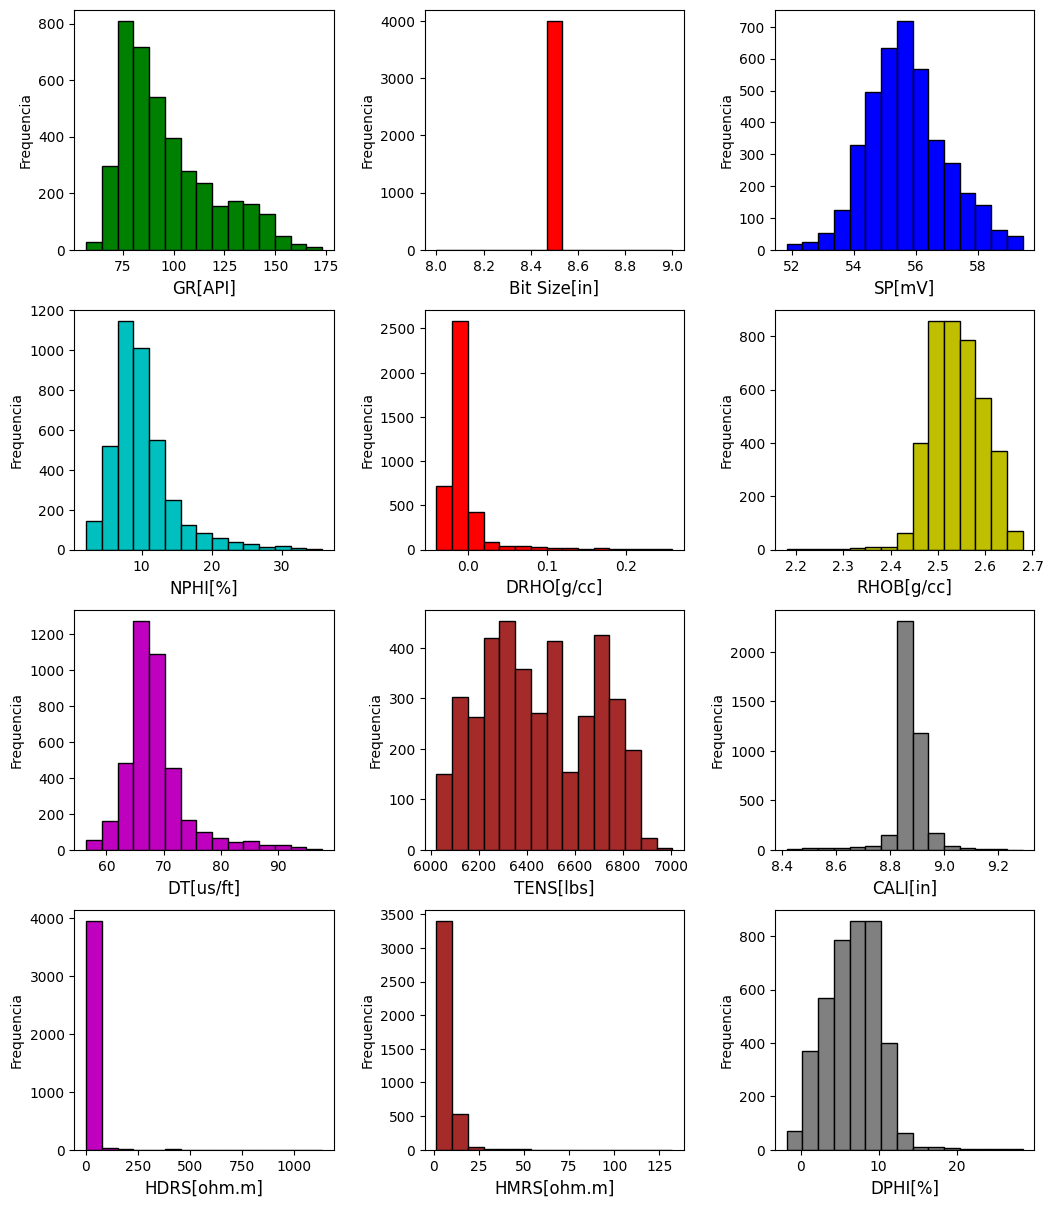

In [31]:
# Histograma do poço teste/treino

logs=df_total.copy()
plt.figure(figsize=(12,18))
plt.subplot(5,3,1)
plt.hist(logs.GR.dropna(), bins=15, color='g', edgecolor='k')
plt.xlabel('GR[API]', fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,2)
plt.hist(logs.BS.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('Bit Size[in]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,3)
plt.hist(logs.SP.dropna(), bins=15, color='b', edgecolor='k')
plt.xlabel('SP[mV]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,4)
plt.hist(logs.NPHI.dropna(), bins=15, color='c', edgecolor='k')
plt.xlabel('NPHI[%]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,5)
plt.hist(logs.DRHO.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('DRHO[g/cc]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,6)
plt.hist(logs.RHOB.dropna(), bins=15, color='y', edgecolor='k')
plt.xlabel('RHOB[g/cc]',fontsize=12)
plt.ylabel('Frequencia')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(5,3,7)
plt.hist(logs.DT.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('DT[us/ft]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,8)
plt.hist(logs.TENS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('TENS[lbs]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,9)
plt.hist(logs.CALI.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('CALI[in]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,10)
plt.hist(logs.HDRS.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('HDRS[ohm.m]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,11)
plt.hist(logs.HMRS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('HMRS[ohm.m]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,12)
plt.hist(logs.DPHI.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('DPHI[%]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)
plt.subplots_adjust(top=0.9, bottom=.1, left=0.10, right=0.9, hspace=0.25, wspace=0.35)
plt.show()

## Perfis do poço

In [32]:
# Chama a função para exibir os principais perfis de poço
def perfis_poco(data,top_depth,bottom_depth):
    
    logs=df_total[(df_total.index >= top_depth) & (df_total.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,20), sharey=True)
    fig.suptitle("Perfis do poço 4-BRSA-814D-RN", fontsize=16)
    fig.subplots_adjust(top=0.85,wspace=0.1)
    
# Configurações dos eixos
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
        
# Primeiro Track: BIT SIZE, CALI E TENS 
        ax3 = ax[0].twiny()
        ax3.set_xlim(6,12)
        ax3.spines['top'].set_position(('outward',0))
        ax3.plot(logs.BS, logs.index, '-b', label= "BS")
        ax3.set_xlabel('Bit Size (in)',color='b')    
        ax3.tick_params(axis='x', colors='b')
        ax3.grid(True)
        
        ax1 = ax[0].twiny()
        ax1.set_xlim(8, 10)
        ax1.spines['top'].set_position(('outward', 40))
        ax1.plot(logs.CALI, logs.index, '--k', label= "CALI (in)")
        ax1.set_xlabel('CALI(in)', color ='k')
        ax1.tick_params(axis='x', colors='k')
        
        ax2 = ax[0].twiny()
        ax2.set_xlim(0,10000)
        ax2.spines['top'].set_position(('outward', 80))
        ax2.plot(logs.TENS, logs.index, '-g', label= "TENS (lb)")
        ax2.set_xlabel('TENS (lb)', color= 'g')
        ax2.tick_params(axis='x', colors='g')
        
        

# Segundo Track: Resistividade - HDRS E HMRS

        ax12 = ax[1].twiny()
        ax12.set_xlim(0.1, 2000)
        ax12.set_xscale('log')
        ax12.spines['top'].set_position(('outward', 0))
        ax12.plot(logs.HMRS, logs.index, '-m', label= "HMRS (ohm.m)")
        ax12.set_xlabel('HMRS(ohm.m)', color= 'm')
        ax12.tick_params(axis='x', colors='m')
        
        ax13 = ax[1].twiny()
        ax13.set_xlim(0.1, 2000)
        ax13.set_xscale('log')
        ax13.spines['top'].set_position(('outward', 40))
        ax13.plot(logs.HDRS, logs.index, '-b', label= "HDRS (ohm.m)")
        ax13.set_xlabel('HDRS(ohm.m)', color= 'b')
        ax13.tick_params(axis='x', colors='b')

# Terceiro Track: Resistividade secundária - HO30, HO90, HT30 E HT90
        ax14 = ax[2].twiny()
        ax14.set_xlim(0.1, 2000)
        ax14.set_xscale('log')
        ax14.grid(True)
        ax14.spines['top'].set_position(('outward', 0))
        ax14.plot(logs.HO30, logs.index, '-r', label="HO30 (m.ohm)")
        ax14.set_xlabel('HO30(m.ohm)', color = 'r')
        ax14.tick_params(axis='x', colors='r')
        
         
        ax15 = ax[2].twiny()
        ax15.set_xlim(0.1, 2000)
        ax15.set_xscale('log')
        ax15.spines['top'].set_position(('outward', 40))
        ax15.plot(logs.HO90, logs.index, '-m', label= "HO90 (m.ohm)")
        ax15.set_xlabel('HO90(m.ohm)', color= 'm')
        ax15.tick_params(axis='x', colors='m')
        
        ax16 = ax[2].twiny()
        ax16.set_xlim(0.1, 2000)
        ax16.set_xscale('log')
        ax16.spines['top'].set_position(('outward', 80))
        ax16.plot(logs.HT30, logs.index, '-r', label= "HT30(m.ohm)")
        ax16.set_xlabel('HT30(m.ohm)', color= 'r')
        ax16.tick_params(axis='x', colors='r')
    
        ax17 = ax[2].twiny()
        ax17.set_xlim(0.1, 2000)
        ax17.set_xscale('log')
        ax17.spines['top'].set_position(('outward', 120))
        ax17.plot(logs.HT90, logs.index, '-b', label= "HT90 (m.ohm)")
        ax17.set_xlabel('HT90(m.ohm)', color= 'b')
        ax17.tick_params(axis='x', colors='b')
        
# Quarto Track: GR, SP E DT 
        ax21 = ax[3].twiny()
        ax21.grid(True)
        ax21.set_xlim(140,40)
        ax21.spines['top'].set_position(('outward', 0))
        ax21.plot(logs.DT, logs.index, '-b', label= "DT (us/ft)")
        ax21.set_xlabel('DT(us/ft)', color= 'b')
        ax21.tick_params(axis='x', colors= 'b')
        
        ax2 = ax[3].twiny()
        ax2.set_xlim(0,300)
        ax2.spines['top'].set_position(('outward', 40))
        ax2.plot(logs.GR, logs.index, '-g', label= "GR (API)")
        ax2.set_xlabel('GR(API)', color= 'g')
        ax2.tick_params(axis='x', colors='g')
        
        ax4 = ax[3].twiny()
        ax4.set_xlim(0,100)
        ax4.spines['top'].set_position(('outward', 80))
        ax4.plot(logs.SP, logs.index, '-m', label= "SP (mV)")
        ax4.set_xlabel('SP(mV)', color= 'm')
        ax4.tick_params(axis='x', colors='m')

# Quinto Track: NPHI, RHOB E DPHI        
        ax22 = ax[4].twiny()
        ax22.grid(True)
        ax22.set_xlim(-15,45)
        ax22.invert_xaxis()
        ax22.spines['top'].set_position(('outward', 80))
        ax22.plot(logs.DPHI, logs.index, '-b', label= "DPHI (%)")
        ax22.set_xlabel('DPHI(%)', color= 'b')
        ax22.tick_params(axis='x', colors= 'b')        
         
        ax23 = ax[4].twiny()
        ax23.grid(True)
        ax23.set_xlim(0, 60)
        ax23.invert_xaxis()
        ax23.spines['top'].set_position(('outward', 0))
        ax23.plot(logs.NPHI, logs.index, '--k', label = "NPHI (%)")
        ax23.set_xlabel('NPHI(frac)', color = 'k')
        ax23.tick_params(axis= 'x', colors='k')
         
        ax24 = ax[4].twiny()
        ax24.set_xlim(1.95, 2.95)
        ax24.spines['top'].set_position(('outward', 40))
        ax24.plot(logs.RHOB, logs.index, '-r', label= "RHOB (g/cc)")
        ax24.set_xlabel('RHOB(g/cc)', color = 'r')
        ax24.tick_params(axis='x', colors= 'r')

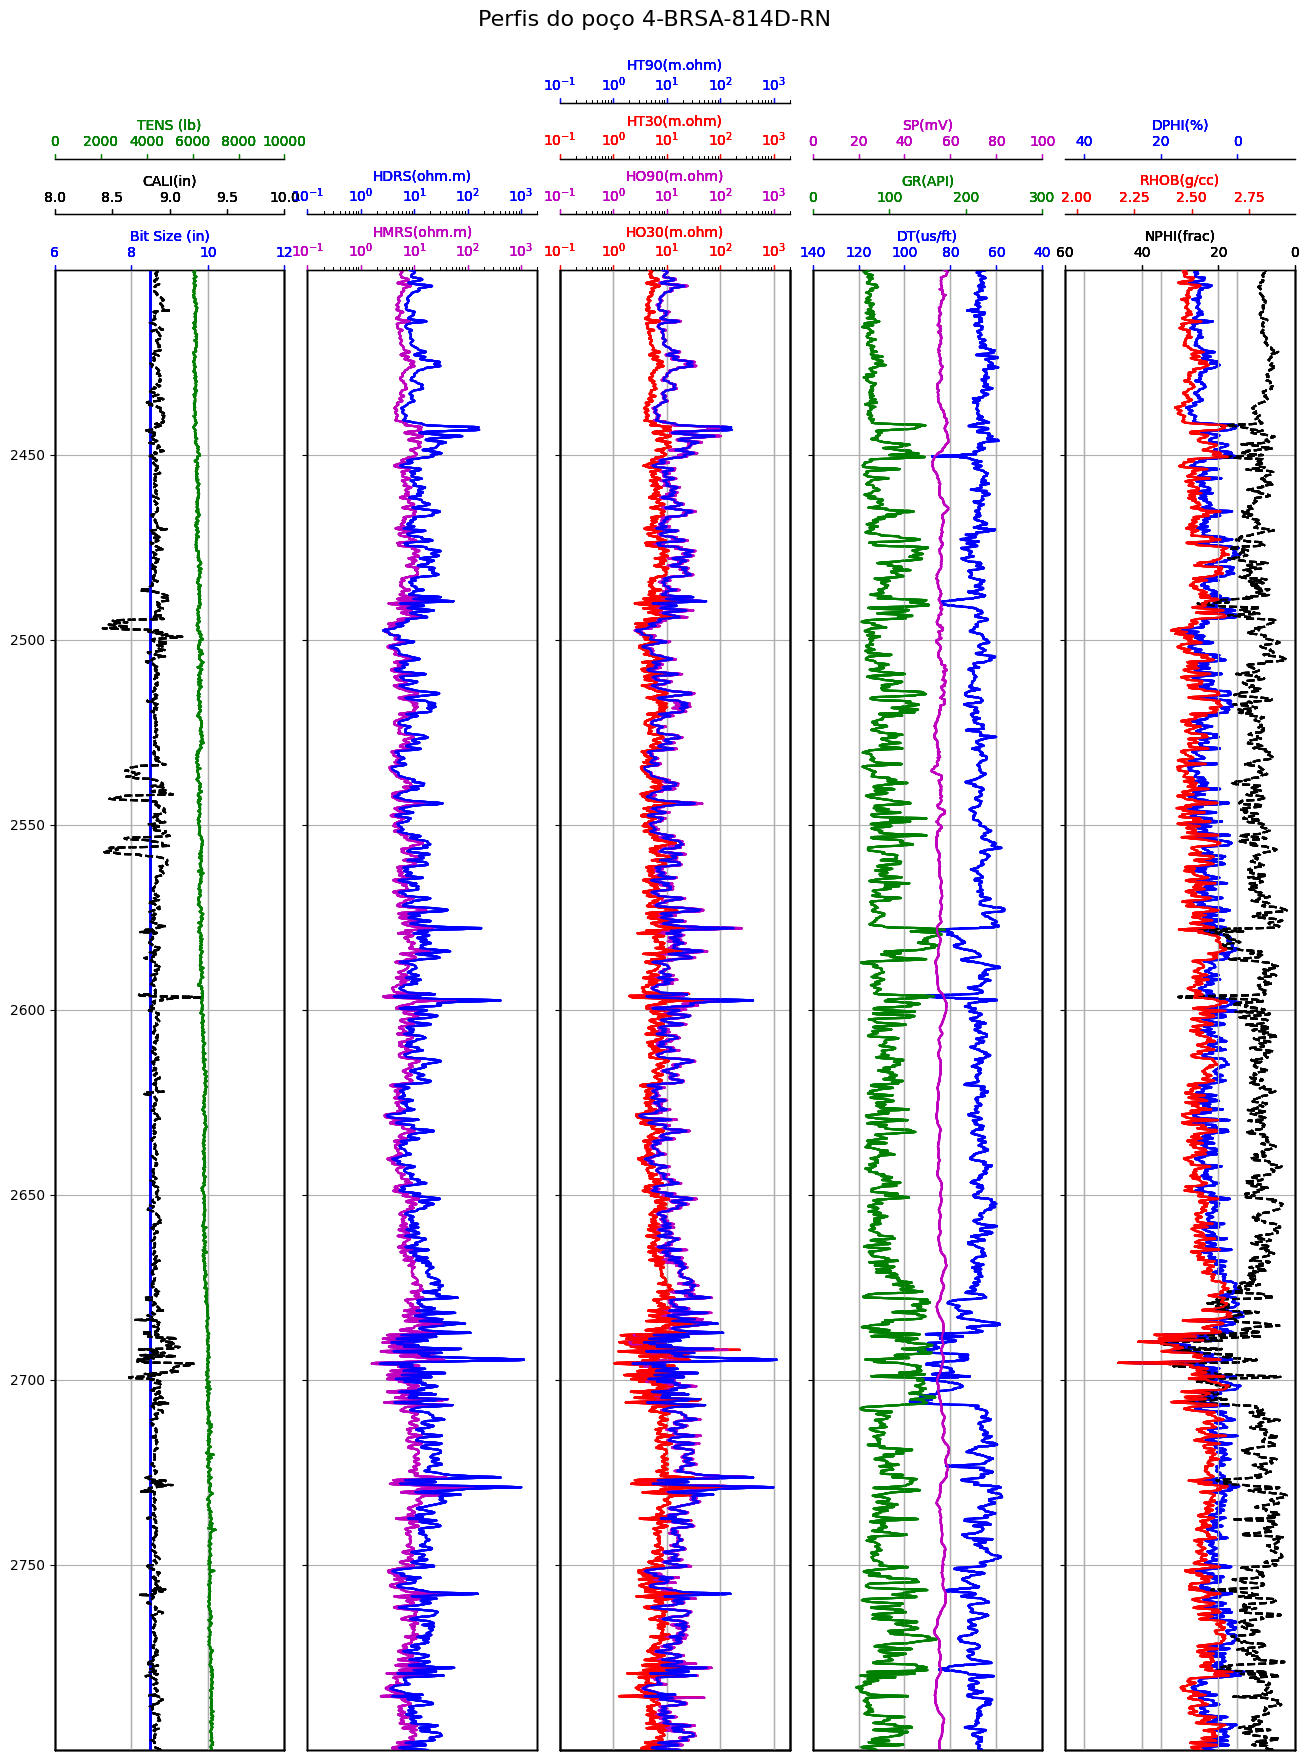

In [37]:
perfis_poco(df_total,df_total.index.min(), df_total.index.max())

Para observar a correlação entre os perfis, elaboramos um mapa de cor e de calor para demonstrar essa configuração. 

In [72]:
logs_usado = logs.loc[:,['CALI','BS','TENS','GR','SP','RHOB','NPHI','DT','HDRS','HMRS','HT30','HT90','ITTI']]
logs_usado

,CALI,BS,TENS,GR,SP,RHOB,NPHI,DT,HDRS,HMRS,HT30,HT90,ITTI
TDEP,,,,,,,,,,,,,
2799.999944,8.909945,8.5,6808.023926,83.345444,55.658554,2.546400,5.715821,66.717262,17.634939,9.065340,7.747621,17.634939,33.216099
2799.899944,8.919298,8.5,6825.693848,82.244156,55.566326,2.533031,5.903707,66.455002,13.565302,7.526206,6.511599,13.565302,32.741501
2799.799944,8.911281,8.5,6819.747559,81.443939,55.488689,2.522833,6.368601,66.455002,10.043540,6.059411,5.320687,10.043540,32.741501
2799.699944,8.903263,8.5,6815.000488,78.254951,55.345119,2.510259,7.016306,67.276978,6.588418,4.447940,3.993806,6.588418,33.477699
2799.599944,8.900590,8.5,6820.526855,74.871849,55.298737,2.509676,7.149610,67.276978,5.858396,4.099573,3.709759,5.858396,33.960701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400.499938,8.890886,8.5,6065.000488,70.383499,58.615112,2.476524,7.686941,66.770279,10.216977,5.987842,5.230122,10.216977,33.778599
2400.399938,8.885541,8.5,6080.865723,72.471199,58.326778,2.477135,7.804165,66.770279,9.961738,5.913856,5.177510,9.961738,31.655399
2400.299938,8.885541,8.5,6092.284180,73.948830,58.069061,2.474627,7.596477,64.993980,9.582106,5.787842,5.083338,9.582106,31.655399


In [73]:
# Gerar o mapa de calor 
# Gerar uma matriz em forma de triângulo

mask = np.zeros_like(logs_usado.corr(method='pearson'), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True],
       [False, False, False,

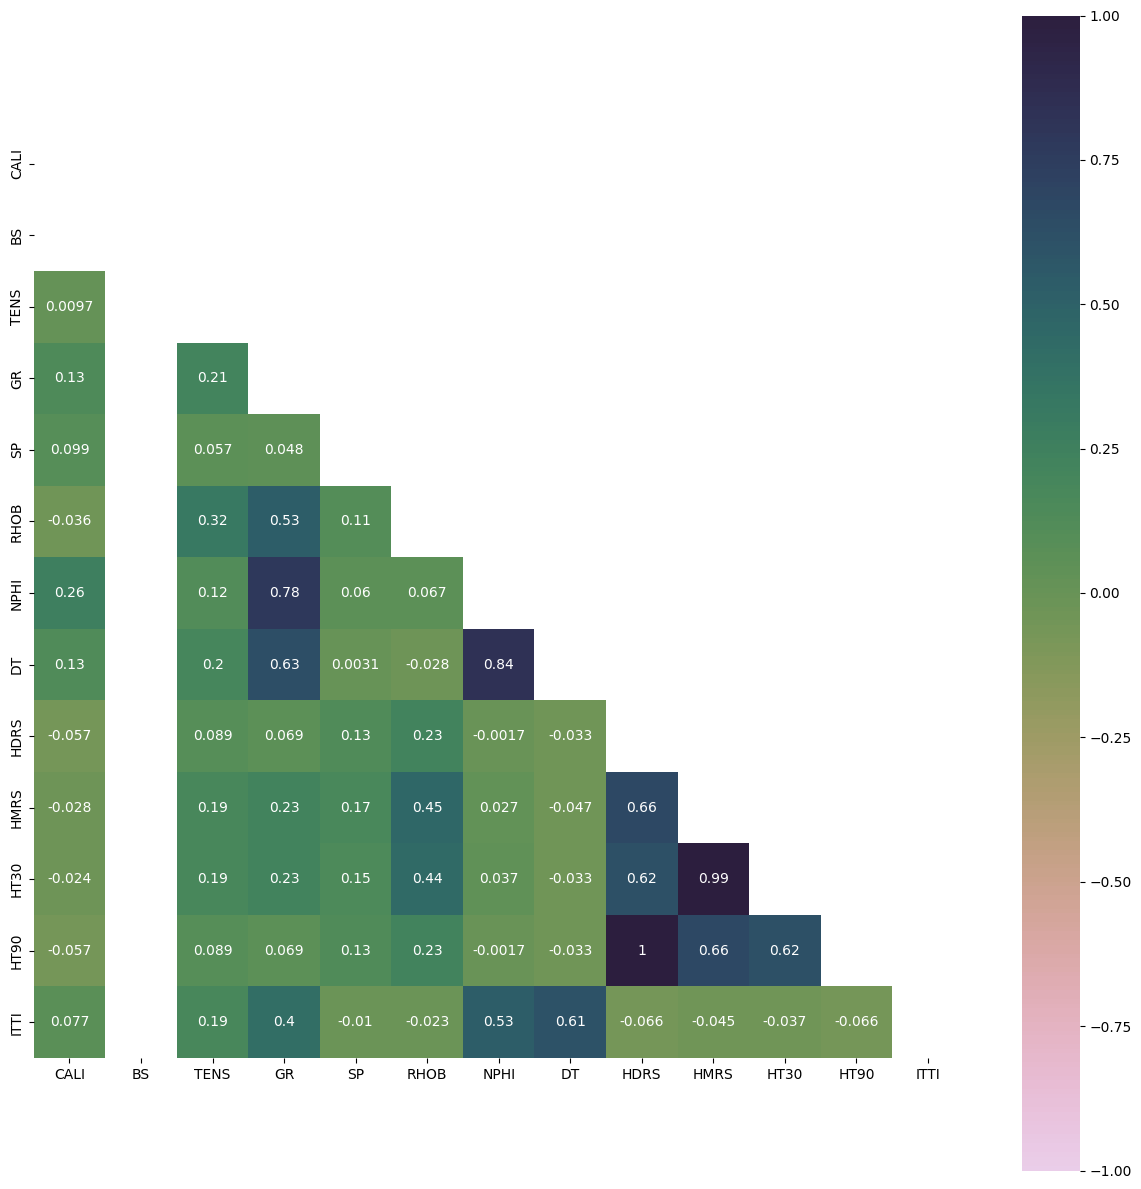

In [75]:
# Gerar um mapa de cor
cmap = srn.cubehelix_palette(n_colors=12, start = -2.25, rot= -1.3, as_cmap=True)

# Desenhar o mapa de calor
plt.figure(figsize=(15,15))
srn.heatmap(logs_usado.corr(method='pearson'), annot = True, mask=mask, cmap =cmap, vmin=-1.0, vmax=1.0, square=True)
plt.show()

### Contagem de Valores Outliers

In [ ]:
#BOX PLOT
from pandas.api.types import is_numeric_dtype
def count_outliers(data):
    outliers_count = {}
    for column in data.columns:
        if is_numeric_dtype(data[column]):
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            outliers_count[column] = len(data[(data[column] < low) | (data[column] > high)])
    return outliers_count

outliers_count = count_outliers(df_total)
print("Número de outliers por coluna:")
for column, count in outliers_count.items():
    print(f"{column}: {count} outliers")

In [ ]:
#DESVIO PADRÃO E MÉDIA
def count_outliers1(data):
    outliers_count = {}
    for column in data.columns:
        if is_numeric_dtype(data[column]):
            mean = data[column].mean()
            std = data[column].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            outliers_count[column] = len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])
    return outliers_count

outliers_count = count_outliers1(df_total)
print("Número de outliers por coluna:")
for column, count in outliers_count.items():
    print(f"{column}: {count} outliers")

### Retirada dos Outliers

In [ ]:
#'CALI','GR'
#DESVIO PADRÃO E MÉDIA
def remove_outliers(data):
    new_data = data.copy()
    for column in ['CALI']:
        if is_numeric_dtype(data[column]):
            mean = data[column].mean()
            std = data[column].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            new_data = new_data[(new_data[column] >= lower_bound) & (new_data[column] <= upper_bound)]
    return new_data

data_without_outliers = remove_outliers(df_total)
print("DataFrame após remoção de outliers:")
data_without_outliers

In [ ]:
#BOX PLOT
def remove_outliers(data):
    new_data = data.copy()
    for column in ['CALI']:
        if is_numeric_dtype(data[column]):
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            new_data = new_data[(new_data[column] >= low) & (new_data[column] <= high)]
    return new_data

data_without_outliers = remove_outliers(df_total)
print("DataFrame após remoção de outliers:")
data_without_outliers

In [ ]:
#sem tratamento de outliers

training_data = df_total.copy()
#training_data = data_without_outliers.copy()
training_data

In [ ]:
# Ordenar os dados pela profundidade em ordem crescente (Mais raso para mais profundo)
training_data = training_data.sort_index()
training_data

In [ ]:
# Deixar o índice na ordem de (0 - 16999)
training_data.reset_index(drop=True, inplace=True)

In [ ]:
training_data

In [ ]:
training_data.index

In [ ]:
# Caso desejasse exportar para excel
training_data.to_excel('training_data.xlsx', index=False)

# Poço para teste

Após realizar todo o tratamento definido como necessário para o poço de treino, 4-BRSA-814D-RN, passamos para analisar as informações do poço de teste (4-BRSA-937-RN).
Abaixo, no código, faremos a leitura e tratamento de um arquivo em formato .xlsx, ou seja, já foi realizada a criação do dataframe com os principais perfis para o projeto e feita a exportação para um documento que pode aberto no excel. 

Para carregar os dados do arquivo e visualizar no jupyter, utilizamos a biblioteca `pandas`, utilizada em larga escala para análise e ciência de dados.

In [ ]:
df_test = pd.read_excel('poco_4_brsa_937d_rn.xlsx')
df_test

In [ ]:
# Definir a profundidade como índice
df_test.set_index('DEPT', inplace=True)

In [ ]:
# Ordenar os dados pela profundidade em ordem crescente (Mais raso para mais profundo) 
df_test = df_test.sort_index()
df_test

In [ ]:
df_test.describe()

In [ ]:
df_test['DPHI'] = df_test['DPHI'] * 100

In [ ]:
df_test.describe()

### Definição de Intervalo de Profundidade para estudo do poço de teste

Devidos erros nos perfis do poço teste, tanto no ínicio como no final da perfilagem, também é necessário fazer um recorte dos dados, pela profundidade, assim como feito para o poço de treino, para que esses dados não prejudiquem a etapa de aprendizado de máquina, o que poderia diminuir a confiança nos resultados.

In [ ]:
valor_prof_min1 = 2700
valor_prof_max1 = 2800

# Excluindo todas as linhas cujo índice é menor que o valor_indice
df_test = df_test.drop(df_test.index[(df_test.index < valor_prof_min1) | (df_test.index > valor_prof_max1)])

In [ ]:
df_test.describe()

In [ ]:
# Histograma do poço teste

logs1=df_test.copy()
plt.figure(figsize=(12,18))
plt.subplot(5,3,1)
plt.hist(logs1.GR.dropna(), bins=15, color='g', edgecolor='k')
plt.xlabel('GR[API]', fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,2)
plt.hist(logs1.BS.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('Bit Size[in]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,3)
plt.hist(logs1.SP.dropna(), bins=15, color='b', edgecolor='k')
plt.xlabel('SP[mV]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,4)
plt.hist(logs1.NPHI.dropna(), bins=15, color='c', edgecolor='k')
plt.xlabel('NPHI[%]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,5)
plt.hist(logs1.DRHO.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('DRHO[g/cc]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,6)
plt.hist(logs1.RHOB.dropna(), bins=15, color='y', edgecolor='k')
plt.xlabel('RHOB[g/cc]',fontsize=12)
plt.ylabel('Frequencia')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(5,3,7)
plt.hist(logs1.DT.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('DT[us/ft]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,8)
plt.hist(logs1.TENS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('TENS[lbs]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,9)
plt.hist(logs1.CALI.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('CALI[in]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,10)
plt.hist(logs1.HDRS.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('HDRS[ohm.m]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,11)
plt.hist(logs1.HMRS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('HMRS[ohm.m]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)

plt.subplot(5,3,12)
plt.hist(logs1.DPHI.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('DPHI[%]',fontsize=12)
plt.ylabel('Frequencia')
#plt.grid(True)
plt.subplots_adjust(top=0.9, bottom=.1, left=0.10, right=0.9, hspace=0.25, wspace=0.35)
plt.show()

In [ ]:
# Chama a função para exibir os principais perfis de poço
def perfil_poco1(data,top_depth,bottom_depth):
    
    logs1=df_test[(df_test.index >= top_depth) & (df_test.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,20), sharey=True)
    fig.suptitle("Perfis do poço 4-BRSA-937D-RN", fontsize=16)
    fig.subplots_adjust(top=0.85,wspace=0.1)
    
# Configurações dos eixos
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
        
# Primeiro Track: BIT SIZE, CALI E TENS
        ax3 = ax[0].twiny()
        ax3.set_xlim(6,12)
        ax3.spines['top'].set_position(('outward',0))
        ax3.plot(logs1.BS, logs1.index, '-b', label= "BS")
        ax3.set_xlabel('Bit Size (in)',color='b')    
        ax3.tick_params(axis='x', colors='b')
        ax3.grid(True)
        
        ax1 = ax[0].twiny()
        ax1.set_xlim(6, 12)
        ax1.spines['top'].set_position(('outward', 40))
        ax1.plot(logs1.CALI, logs1.index, '--k', label= "CALI (in)")
        ax1.set_xlabel('CALI(in)', color ='k')
        ax1.tick_params(axis='x', colors='k')
        
        ax2 = ax[0].twiny()
        ax2.set_xlim(0,10000)
        ax2.spines['top'].set_position(('outward', 80))
        ax2.plot(logs1.TENS, logs1.index, '-g', label= "TENS (lb)")
        ax2.set_xlabel('TENS (lb)', color= 'g')
        ax2.tick_params(axis='x', colors='g')
        
        

# Segundo Track: Resistividade - HDRS E HMRS
        
        ax12 = ax[1].twiny()
        ax12.set_xlim(0.1, 2000)
        ax12.set_xscale('log')
        ax12.spines['top'].set_position(('outward', 0))
        ax12.plot(logs1.HMRS, logs1.index, '-m', label= "HMRS (ohm.m)")
        ax12.set_xlabel('HMRS(ohm.m)', color= 'm')
        ax12.tick_params(axis='x', colors='m')
        
        ax13 = ax[1].twiny()
        ax13.set_xlim(0.1, 2000)
        ax13.set_xscale('log')
        ax13.spines['top'].set_position(('outward', 40))
        ax13.plot(logs1.HDRS, logs1.index, '-b', label= "HDRS (ohm.m)")
        ax13.set_xlabel('HDRS(ohm.m)', color= 'b')
        ax13.tick_params(axis='x', colors='b')

# Terceiro Track: Resistividade secundária - HO30, HO90, HT30 E HT90
        ax14 = ax[2].twiny()
        ax14.set_xlim(0.1, 2000)
        ax14.set_xscale('log')
        ax14.grid(True)
        ax14.spines['top'].set_position(('outward', 0))
        ax14.plot(logs1.HO30, logs1.index, '-r', label="HO30 (m.ohm)")
        ax14.set_xlabel('HO30(m.ohm)', color = 'r')
        ax14.tick_params(axis='x', colors='r')
        
         
        ax15 = ax[2].twiny()
        ax15.set_xlim(0.1, 2000)
        ax15.set_xscale('log')
        ax15.spines['top'].set_position(('outward', 40))
        ax15.plot(logs1.HO90, logs1.index, '-m', label= "HO90 (m.ohm)")
        ax15.set_xlabel('HO90(m.ohm)', color= 'm')
        ax15.tick_params(axis='x', colors='m')
        
        ax16 = ax[2].twiny()
        ax16.set_xlim(0.1, 2000)
        ax16.set_xscale('log')
        ax16.spines['top'].set_position(('outward', 80))
        ax16.plot(logs1.HT30, logs1.index, '-r', label= "HT30(m.ohm)")
        ax16.set_xlabel('HT30(m.ohm)', color= 'r')
        ax16.tick_params(axis='x', colors='r')
    
        ax17 = ax[2].twiny()
        ax17.set_xlim(0.1, 2000)
        ax17.set_xscale('log')
        ax17.spines['top'].set_position(('outward', 120))
        ax17.plot(logs1.HT90, logs1.index, '-b', label= "HT90 (m.ohm)")
        ax17.set_xlabel('HT90(m.ohm)', color= 'b')
        ax17.tick_params(axis='x', colors='b')
        
# Quarto Track: GR, SP E DT
        ax21 = ax[3].twiny()
        ax21.grid(True)
        ax21.set_xlim(140,40)
        ax21.spines['top'].set_position(('outward', 0))
        ax21.plot(logs1.DT, logs1.index, '-b', label= "DT (us/ft)")
        ax21.set_xlabel('DT(us/ft)', color= 'b')
        ax21.tick_params(axis='x', colors= 'b')
        
        ax2 = ax[3].twiny()
        ax2.set_xlim(0,300)
        ax2.spines['top'].set_position(('outward', 40))
        ax2.plot(logs1.GR, logs1.index, '-g', label= "GR (API)")
        ax2.set_xlabel('GR(API)', color= 'g')
        ax2.tick_params(axis='x', colors='g')
        
        ax4 = ax[3].twiny()
        ax4.set_xlim(-300,100)
        ax4.spines['top'].set_position(('outward', 80))
        ax4.plot(logs1.SP, logs1.index, '-m', label= "SP (mV)")
        ax4.set_xlabel('SP(mV)', color= 'm')
        ax4.tick_params(axis='x', colors='m')

# Quinto Track: NPHI, RHOB E DPHI        
        ax22 = ax[4].twiny()
        ax22.grid(True)
        ax22.set_xlim(0,60)
        ax22.invert_xaxis()
        ax22.spines['top'].set_position(('outward', 80))
        ax22.plot(logs1.DPHI, logs1.index, '-b', label= "DPHI (%)")
        ax22.set_xlabel('DPHI(frac)', color= 'b')
        ax22.tick_params(axis='x', colors= 'b')        
         
        ax23 = ax[4].twiny()
        ax23.grid(True)
        ax23.set_xlim(0, 60)
        ax23.invert_xaxis()
        ax23.spines['top'].set_position(('outward', 0))
        ax23.plot(logs1.NPHI, logs1.index, '--k', label = "NPHI (%)")
        ax23.set_xlabel('NPHI(frac)', color = 'k')
        ax23.tick_params(axis= 'x', colors='k')
         
        ax24 = ax[4].twiny()
        ax24.set_xlim(1.95, 2.95)
        ax24.spines['top'].set_position(('outward', 40))
        ax24.plot(logs1.RHOB, logs1.index, '-r', label= "RHOB (g/cc)")
        ax24.set_xlabel('RHOB(g/cc)', color = 'r')
        ax24.tick_params(axis='x', colors= 'r')

In [ ]:
perfil_poco1(df_test,df_test.index.min(), df_test.index.max())

In [ ]:
# Gerar o mapa de calor 
# Gerar uma matriz em forma de triângulo

mask = np.zeros_like(logs1.corr(method='pearson'), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Gerar um mapa de cor
cmap = srn.cubehelix_palette(n_colors=12, start = -2.25, rot= -1.3, as_cmap=True)

# Desenhar o mapa de calor
plt.figure(figsize=(15,15))
srn.heatmap(logs1.corr(method='pearson'), annot = True, mask=mask, cmap =cmap, vmin=-1.0, vmax=1.0, square=True)
plt.show()


In [ ]:
test_data = df_test.copy()

In [ ]:
# Deixar o índice na ordem de (0 - 16999)
test_data.reset_index(drop=True, inplace=True)

In [ ]:
# Adicionar uma coluna chamada 'POÇO' para indicar o tipo de poço cada linha dos dados está representada. 
# Esta etapa é realizada, pois posteriormente os dados dos poços de treino e teste serão todos adicionados a um mesmo dataframe
# Logo, os dados serão diferenciados por essa nova coluna
training_data['POÇO']= np.nan
training_data = training_data.replace(np.nan, 'Treino')
test_data['POÇO']= np.nan
test_data = test_data.replace(np.nan, 'Teste')

In [ ]:
training_data.head(10)

In [ ]:
test_data.head(10)

União dos dados dos poços:

A concatenação dos dados é feita também pela biblioteca pandas por meio da linha de código abaixo.

In [ ]:
df_final = pd.concat([training_data,test_data],ignore_index=True)

In [ ]:
# Ver as informações do dataframe completo
df_final.describe()

In [ ]:
df_final.head(5)

In [ ]:
df_final.tail(5)

# Aprendizado de Máquina Não-Supervisionado

### Clusterização por KMeans

Para realizar a clusterização, ou seja, o agrupamento dos dados, vamos informar à máquina apenas aqueles perfis que determinamos como cruciais para a definição dos clusters e que apresentem menor quantidade de erros no aprendizado.

In [ ]:
# Descartar recursos e salvar em um novo banco de dados
# Novo dataframe deve conter apenas 'CALI', 'DT' e 'GR'.
#df_final_1=df_final.drop(columns=['SP','PE','DRHO','HMRS','POÇO','HO30','HO90','HT30','HT90','BS'], axis=1)
df_final_1=df_final.drop(columns=['CALI','PE','DRHO','DPHI','TENS','POÇO','HT30','HT90','BS','HDRS','ITTI','HO30','HO90'], axis=1)

In [ ]:
df_final_1

In [ ]:
df_final_1.describe()

Devido os dados apresentarem diferentes escalas, é necessário padronizar (escalar) os dados, o que significa transformar as características (variáveis) para que elas tenham média zero e desvio padrão igual a um.

É uma etapa importante no pré-processamento de dados antes de aplicar algoritmos de aprendizado de máquina, como análise de fator (Factor Analysis) ou agrupamento (KMeans).

In [ ]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Padronizar os dados
scaler = StandardScaler()
df_final_2 = scaler.fit_transform(df_final_1)

# Definir um intervalo de valores para n_components
n_components_range = range(1, 15)  # Escolha o intervalo que você desejar

# Inicialize listas para armazenar as variâncias explicadas
explained_variances = []

# Realize uma análise fatorial para cada valor de n_components
for n_components in n_components_range:
    fa_model = FactorAnalysis(n_components=n_components)
    fa_model.fit(df_final_2)
    explained_variance = np.sum(fa_model.noise_variance_)
    explained_variances.append(explained_variance)

# Plote a variância explicada em relação a n_components
import matplotlib.pyplot as plt

plt.plot(n_components_range, explained_variances, marker='o', linestyle='-')
plt.xlabel('Número de Componentes (n_components)')
plt.ylabel('Variância Explicada')
plt.title('Análise de Variância Explicada')
plt.grid(True)
plt.show()


In [ ]:
# Histograma dos dados transformados
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.hist(df_final_2[:,0])

plt.subplot(332)
plt.hist(df_final_2[:,1],color='r')

plt.subplot(333)
plt.hist(df_final_2[:,2],color='g')

plt.subplot(334)
plt.hist(df_final_2[:,3],color='k')

plt.subplot(335)
plt.hist(df_final_2[:,4],color='b')

plt.subplot(336)
plt.hist(df_final_2[:,5],color='m')
plt.show()

In [ ]:
# Realizar a análise de fator, que é uma técnica de redução de dimensionalidade e exploração de estrutura subjacente em dados.
# Reduzir a dimensionalidade dos dados para 2 componentes principais.
fa_model = FactorAnalysis(n_components = 6)
fa_model.fit(df_final_2)
factor_data = fa_model.transform(df_final_2)

In [ ]:
# Descobrir o melhor número de clusters para a predição das litofácies

inertias = []
means=[]
maxK=20

for k in range(1, maxK):
    kmeans=KMeans(n_clusters=k, random_state=0,n_init='auto').fit(factor_data)
    means.append(k)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(means, inertias, 'o-')
plt.ylabel('Soma dos erros quadrados', fontsize=20)
plt.xlabel('Número de clusters',fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

In [ ]:
# Ajustar os recursos com 3 clusters
kmeans=KMeans(n_clusters=3, random_state=0,n_init='auto')
kmeans.fit(factor_data)

In [ ]:
# Adicionar uma coluna chamada 'Cluster' e definir o valor para cada linha dos dados

df_final['Cluster']= kmeans.labels_

In [ ]:
df_final

In [ ]:
# Histograma dos clusters do poço de treino

plt.hist(df_final100.Cluster[df_final100.POÇO=='Treino'])
plt.show()

In [ ]:
plt.hist(df_final100['POÇO'])
plt.show()

In [ ]:
# Histograma dos clusters do poço de teste

plt.hist(df_final100.Cluster[df_final100.POÇO=='Teste'])
plt.show()

In [ ]:
facies_colors = srn.color_palette("Set1", 3)

In [ ]:
facies_colors = ['#00FF00','#FFFF00','#FF0000']

In [ ]:
def facies_poco(logs, facies_colors, label):
    
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    #make sure logs are sorted by depth 
    #logs = logs.sort_values(by='index')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.index.min(); zbot=logs.index.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs.GR, logs.index, '-g')
    ax[1].plot(logs['NPHI'], logs.index, '-')
    ax[2].plot(logs['DT'], logs.index, '-', color='r')
    ax[3].plot(logs['HMRS'], logs.index, '-', color='k')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=4)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((20*' ').join(['Cluster1', 'Cluster2','Cluster3'
                                ]), fontsize=12)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel('GR', fontsize=12)
    ax[0].set_xlim(0,200)
    ax[0].set_ylabel('Sample', fontsize=16)
    ax[0].tick_params(labelsize=12)
    ax[0].grid(False)
    ax[1].set_xlabel("NPHI", fontsize=12)
    ax[1].set_xlim(0,60)
    ax[1].invert_xaxis()
    ax[1].grid(False)
    ax[1].tick_params(labelsize=12)
    ax[2].set_xlabel("DT[g/cc]", fontsize=12)
    ax[2].set_xlim(140, 40)
    ax[2].grid(False)
    ax[2].tick_params(labelsize=12)
    ax[3].set_xlabel("HMRS", fontsize=12)
    ax[3].set_xlim(0.1, 2000)
    ax[3].set_xscale('log')
    ax[3].grid(False)
    ax[3].tick_params(labelsize=12)
    ax[4].set_xlabel('Facies', fontsize=16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    
    return f

In [ ]:
#training data cluster log
#facies_poco(training_data[training_data.POÇO=='Treino'],facies_colors, label='Cluster')
facies_poco(df_final[df_final.POÇO=='Treino'],facies_colors, label='Cluster')
plt.show()

In [ ]:
# Test well cluster plot
facies_poco(df_final[df_final.POÇO=='Teste'],facies_colors, label='Cluster')
plt.show()